In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from '/home/wecapstor1/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.modeling.models import CompoundNormSpectralModel, PowerLawNormPenSpectralModel
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')

sys.path.append('../')
import Dataset_load 
from Dataset_Creation import sys_dataset


## Read dataset

In [3]:
dataset_asimov = Dataset_load.create_asimov()

<WCSAxes: >

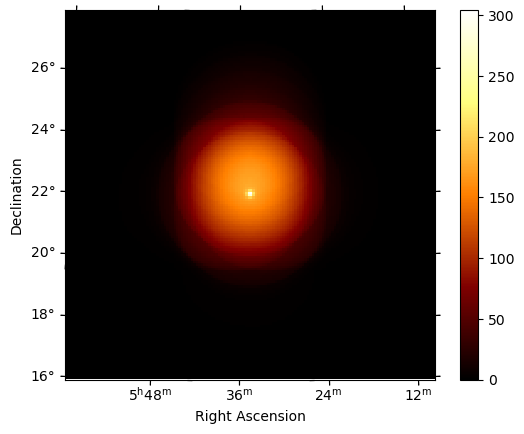

In [4]:
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)

<WCSAxes: >

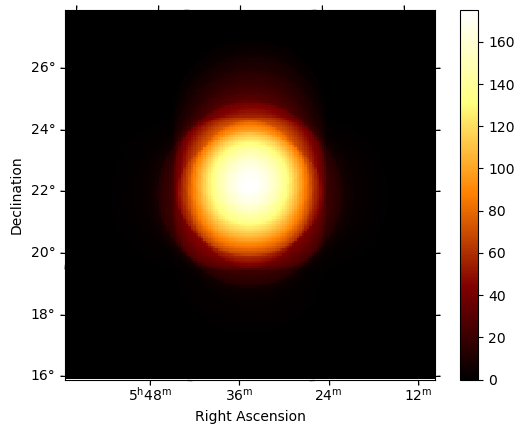

In [5]:
dataset_asimov.npred_background().sum_over_axes().plot(add_cbar=1)

In [6]:
print(dataset_asimov.models)

DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : 3YyPVecd-bkg
  Datasets names            : ['3YyPVecd']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  

## Asimov Cases

In [7]:
from gammapy.modeling.models import CompoundNormSpectralModel, PowerLawNormPenSpectralModel

In [8]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value


norm = 0.1
tilt = 0.025



In [22]:

from gammapy.modeling.models.IRF import IRFModel, ERecoIRFModel, IRFModels, EffAreaIRFModel

effareamodel = EffAreaIRFModel()
erecomodel = ERecoIRFModel()
IRFmodels = IRFModels(eff_area_model= effareamodel,
                      e_reco_model = erecomodel,
                             datasets_names = dataset_asimov.name)


print(IRFmodels.parameters.names)


sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0, 
                        tilt = 0,
                        bias = 0,
                        resolution = 0,
                        rnd = False,
                        e_reco_creation=10)
dataset_cor_N = sys_d_cor.create_dataset_N(10)
dataset_cor = sys_d_cor.create_dataset()




zero = 1e-12

    
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((6, 6))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/zero**2, 1/zero**2, 1/zero**2, 1/zero**2, 1/norm**2, 1/tilt**2])


dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix


# set bkg model:
import operator
compoundnorm  = CompoundNormSpectralModel(model1  = PowerLawNormSpectralModel(),
                                         model2 = PowerLawNormPenSpectralModel(),
                                         operator =  operator.mul)

bkg = FoVBackgroundModel(dataset_name=dataset_cor_N.name,
                        spectral_model = compoundnorm)
dataset_cor_N.models['dataset N-irf'].parameters.freeze_all()
models = Models(dataset_cor_N.models)
models.pop('dataset N-bkg')
models.append(bkg)
dataset_cor_N.models = models
dataset_cor_N.models['dataset N-bkg'].parameters['tilt_nuisance'].frozen = False
dataset_cor_N.models['dataset N-bkg'].parameters['tilt'].frozen = False

datasets  = [dataset_cor_N]

    
    
    
print(dataset_cor_N.models)
print(dataset_cor.models)    
    

DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: IRFModels

  Name                      : dataset N-irf
  Datasets names            : dataset N
  EReco  model type         : ERecoIRFModel
  Eff area  model type      : EffA

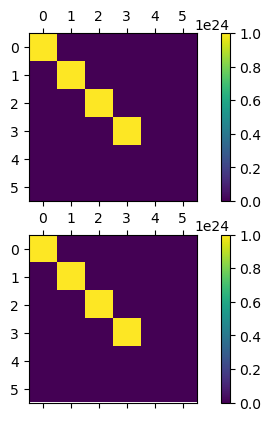

In [23]:
fig, ax = plt.subplots(2,1)
#ax = fig.add_subplot(111)
cax = ax[0].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);
cax = ax[1].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]

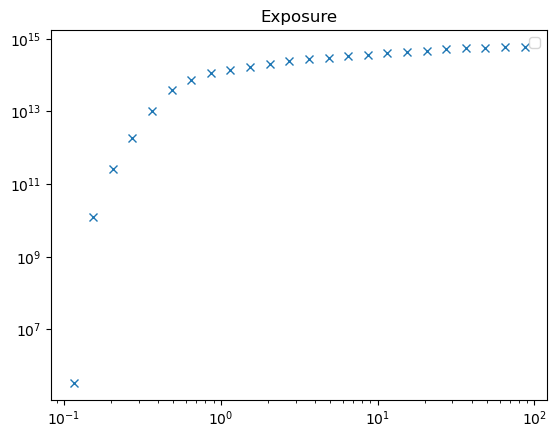

In [24]:
e_bins = dataset_cor_N.geoms['geom'].axes[0].center.value
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)


plt.plot(e_bins,sum_e(dataset_cor_N.npred_exposure().data ), 'x')
plt.title("Exposure")

plt.legend()
plt.loglog()

corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 291              │
│ EDM = 6.23e-08 (Goal: 2e-06)     │           time = 52.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────────┬───────────┬───────────┬────────────┬────────────┬────

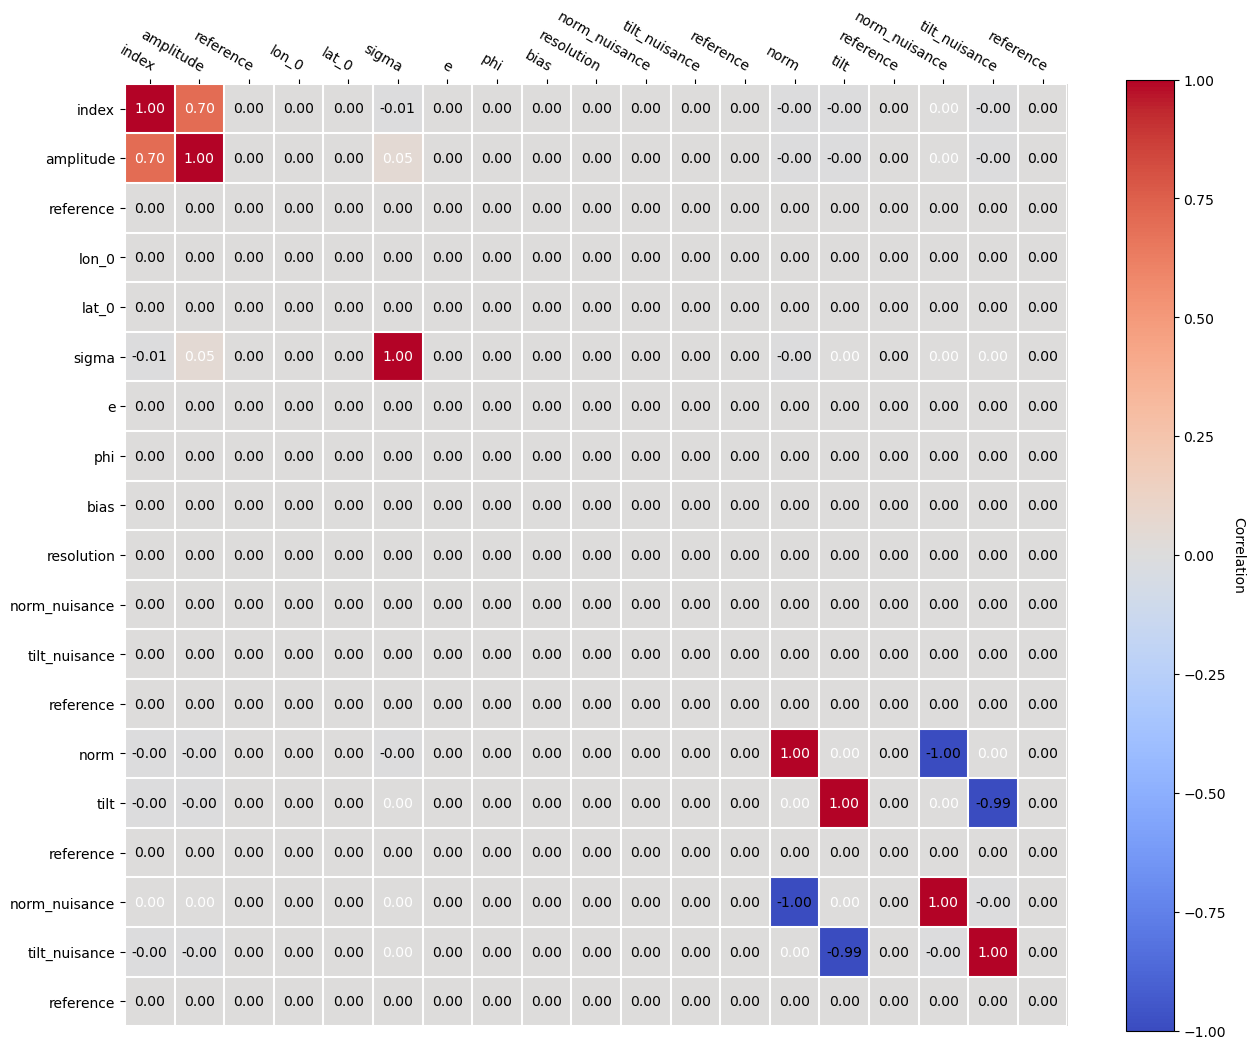

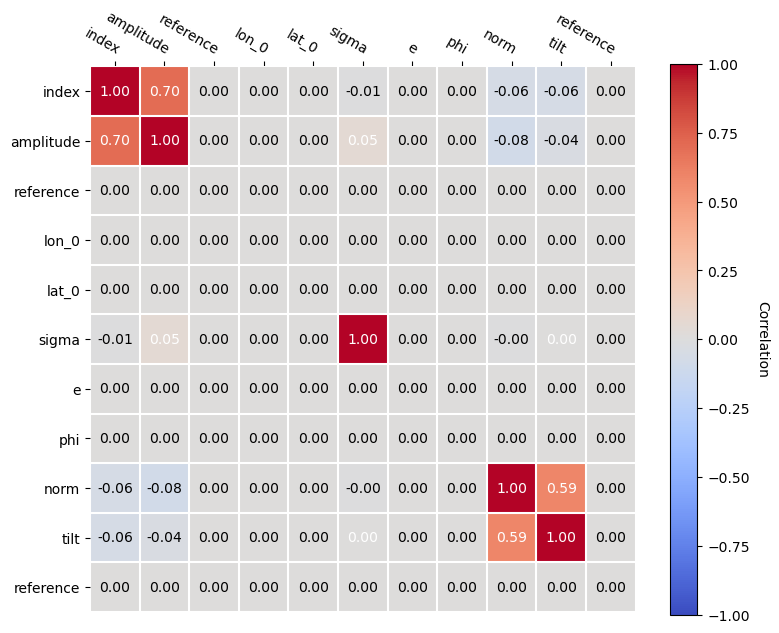

In [25]:
%%time
fitting = True

if fitting:

    print("corr")
    fit_cor = Fit(store_trace=True)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_cor_N)
    dataset_cor_N.models.covariance = fit_cor.covariance(dataset_cor_N).matrix
    dataset_cor_N.models.covariance.plot_correlation()
    print(fit_cor.minuit)

    print("saving")
    path = f'data/2_model_nui_{norm}_tilt_{tilt}.yml'
    dataset_cor_N.models.write(path,overwrite=True)
    
    
    print("corr")
    fit_cor = Fit(store_trace=True)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_cor)
    dataset_cor.models.covariance = fit_cor.covariance(dataset_cor).matrix
    dataset_cor.models.covariance.plot_correlation()
    print(fit_cor.minuit)

    print("saving")
    path = f'data/2_model_{norm}_tilt_{tilt}.yml'
    dataset_cor.models.write(path,overwrite=True)
    
else:
    print("read")
    path = f'data/2_model_nui_{norm}_tilt_{tilt}.yml'
    dataset_cor_N = Dataset_load.load_dataset_N(dataset_cor_N, path)        
         
    path = f'data/2_model_{norm}_tilt_{tilt}.yml'
    dataset_cor = Dataset_load.load_dataset_N(dataset_cor_N, path)     



(<WCSAxes: >, <Axes: xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

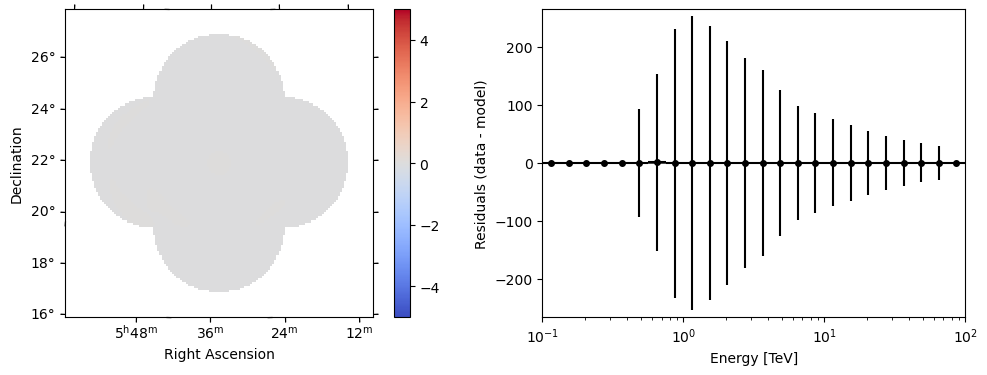

In [26]:
dataset_cor_N.plot_residuals()

<WCSAxes: >

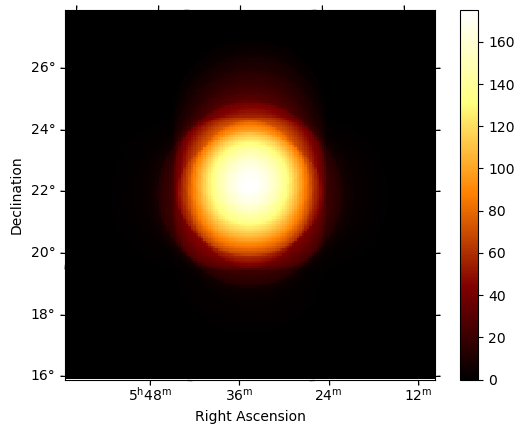

In [27]:
dataset_cor_N.npred_background().sum_over_axes().plot(add_cbar=1)

In [28]:
datasets_short = [dataset_cor_N,dataset_cor]
amplitudes_N = []
indices_N = []
norms_N = []
tilts_N = []


m = dataset_asimov.models[0]
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes_N.append((value, error))
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices_N.append((value, error))
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms_N.append((value, error))
value = dataset_asimov.background_model.parameters['tilt'].value 
error = dataset_asimov.background_model.parameters['tilt'].error
tilts_N.append((value, error))

for i,d in enumerate(datasets_short):
    m = d.models[0]
    
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes_N.append((value, error))

    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices_N.append((value, error))
    
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    norms_N.append((value, error))

    value = d.background_model.parameters['tilt'].value 
    error = d.background_model.parameters['tilt'].error
    tilts_N.append((value, error))


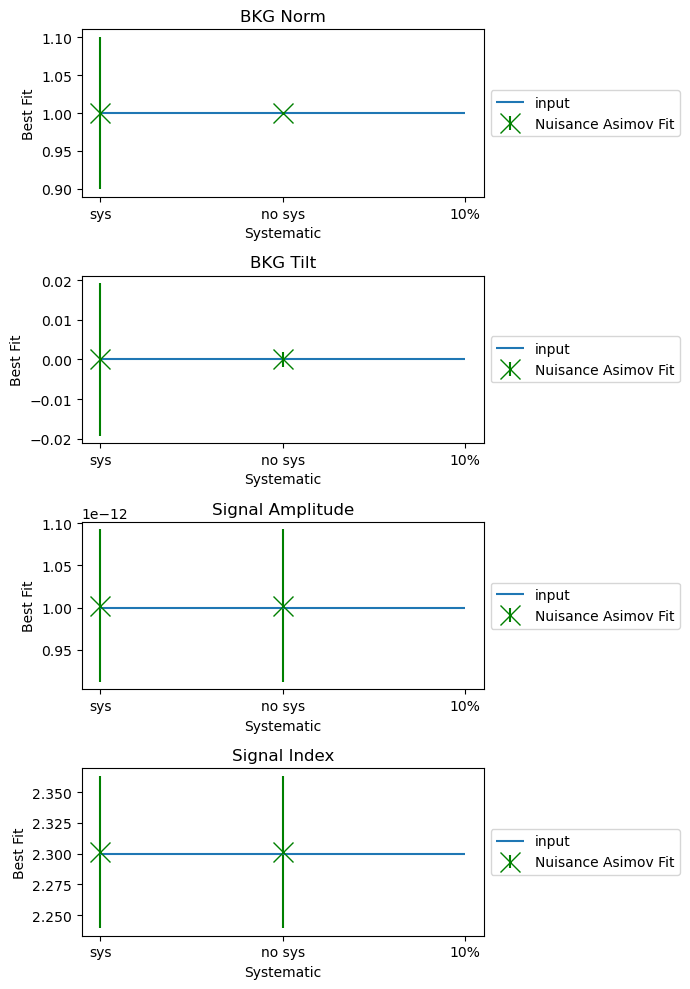

In [29]:
fig, axs = plt.subplots(4,1,figsize=(7,10))

axs[0].set_title("BKG Norm")
axs[1].set_title("BKG Tilt")
axs[2].set_title("Signal Amplitude")
axs[3].set_title("Signal Index")


labels_sys = [ 'sys', 'no sys', '10%']
label = "Nuisance Asimov Fit"

for i, a in enumerate(norms_N[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[0].hlines( norms_N[0][0], 1, 3, label = "input")


for i, a in enumerate(tilts_N[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[1].hlines( tilts_N[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes_N[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( amplitudes_N[0][0], 1, 3, label = "input")

for i, a in enumerate(indices_N[1:]):
    axs[3].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[3].hlines( indices_N[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1, 0.5))
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels_sys)

plt.tight_layout()    


In [34]:
print(dataset_cor.models[0])

SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.301   +/-    0.06             
    amplitude                     :   1.00e-12   +/- 9.0e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.01 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         




In [33]:
print(dataset_cor_N.models[0])

SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.301   +/-    0.06             
    amplitude                     :   1.00e-12   +/- 9.0e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.01 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         




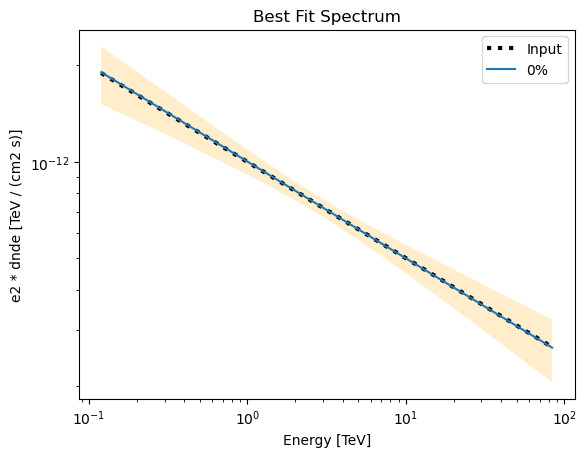

In [31]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')


dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "0%")
                                   
dataset_cor_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='orange')


                               


plt.legend()

plt.title("Best Fit Spectrum")
fig = plt.gcf()
#fig.savefig("plots/2_spectrum.pdf")

-3.944175344861184e-07 0.10067594647119092
6.186192965630861e-07 0.019152404586199254


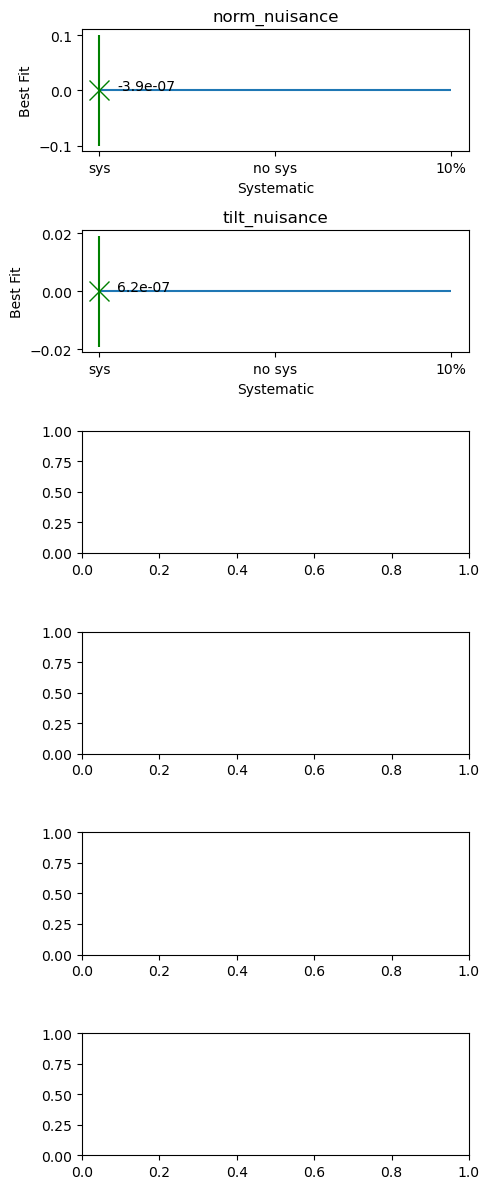

In [32]:
n_nui = len(dataset_cor_N.models.parameters.penalised_parameters)
fig, a  = plt.subplots(n_nui, 1, figsize = (5,2* n_nui))
if n_nui ==1:
    a = [a]
label = 'Nuisance Fit'
iss = [1.1, 1.9, 2.7]
for j, par_name in enumerate(dataset_cor_N.background_model.parameters.penalised_parameters.names):
    for i, d in enumerate([dataset_cor_N]):
        value = d.background_model.parameters[par_name].value
        error = d.background_model.parameters[par_name].error
        print(value, error)

        a[j].errorbar(x= i+1, y = value, yerr = error, fmt= 'x', color =  'green',markersize=14,
                       label = label)
        a[j].text(iss[i],-value, f'{value:.2}', )
    a[j].hlines( 0., 1, 3, label = "input")

    a[j].set_ylabel('Best Fit' ); 
    a[j].set_title(par_name)
    a[j].set_xlabel('Systematic'); 
    a[j].set_xticks(np.arange(3)+1,labels_sys);

plt.tight_layout()
#fig.savefig("plots/2_best_fit_nui.pdf")

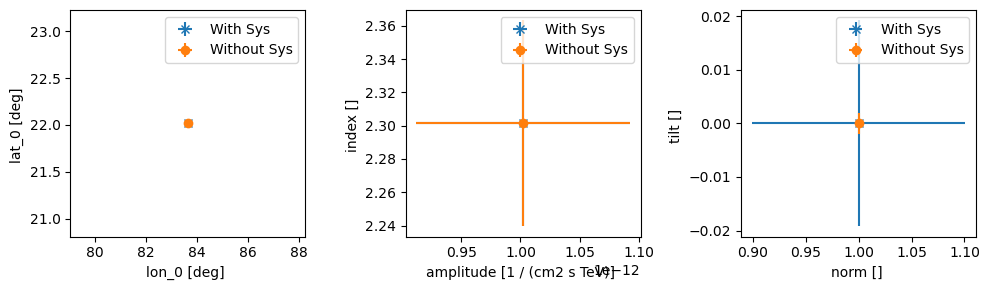

In [40]:
def plot_par(par1, par2, label,fmt, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                label = label)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name):

    fig, ax = plt.subplots(1,3, figsize = (10,3))
    par1, par2 = 'amplitude', 'alpha'
    pars = [('lon_0', 'lat_0'),('amplitude', 'index'), ('norm', 'tilt'), ]
    for i, p in enumerate(pars):
        for j, m  in enumerate (models_list):
            plot_par(m.parameters[p[0]],
                 m.parameters[p[1]],
                    label= labels[j],
                     fmt = fmts[j],
                    ax = ax[i],
                    )

    plt.tight_layout()
fmts  =['x', 'o']
labels = ['With Sys', 'Without Sys']
models_list = [dataset_cor_N.models, dataset_cor.models]
plot_source_par(0)
plt.tight_layout()